In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import numpy as np
import pywt
from statsmodels.graphics.tsaplots import plot_pacf


**Dataset: Metro Interstate Traffic Volume**  
See : https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume  
Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.   
Hourly weather features and holidays included for impacts on traffic volume.

**1. Import et mise en forme de la donnée**

In [2]:
df = pd.read_csv(r'data\Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
print(df.shape)
df.head(5)

(48204, 9)


holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

In [3]:
df.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
print(df.shape)

(40575, 9)


In [4]:
missing_percentage = (df.isna().sum() / len(df)) * 100
rounded_missing_percentage = round(missing_percentage, 2)
print(rounded_missing_percentage[rounded_missing_percentage > 0])

holiday    99.87
dtype: float64


Pas de valeurs manquantes à part pour la colonne **holiday**.  
Néammoins, on va remarquer que il y a des valeurs manquantes "cachées" : les time stamps ne sont pas continues.  
C'est à dire qu'il y a pas d'observations pour tous les jours et heures.

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'])
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')

missing_timestamps = full_range.difference(df['date_time'])

print("Timestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)


gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())


# missing value per year
missing_by_year = pd.Series(missing_timestamps).dt.year.value_counts().sort_index()
print("\nValeurs manquantes par années")
print(missing_by_year)

Timestamps manquants :
22.78929040360792

La plus longue période de données manquantes est de 7386 heures : entre le 2014-08-08 02:00:00 et le 2015-06-11 19:00:00

Valeurs manquantes par années
2012      72
2013    1466
2014    4259
2015    5167
2016     946
2017      47
2018      19
Name: count, dtype: int64


Plusieurs problèmes:
- 23% de valeurs manquantes c'est assez élevé.
- Aucune valeurs quasiment pendant un an (Aout 2014 à Juin 2015) : inimputable

=> On va couper le dataset et ne garder que les 3,5 dernières années à peu près. On peut modifier la date pour réduire les valeurs manquantes quitte à un peu réduire le nombre total d'observation.

In [ ]:
df = df[(df["date_time"] >= "2015-10-27 07:00:00")]  # & (df["date_time"] <= "2015-10-27 08:00:00")]
print("Nombre d'observations après tronquage", len(df))
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')

missing_timestamps = full_range.difference(df['date_time'])

print("\nTimestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)

gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())


# missing value per year
missing_by_year = (pd.Series(missing_timestamps).dt.year.value_counts()).sort_index()
print(missing_by_year)

Nombre d'observations après tronquage 23979

Timestamps manquants :
6.594733561857276

La plus longue période de données manquantes est de 9 heures : entre le 2017-02-13 16:00:00 et le 2017-02-14 00:00:00
2015    681
2016    946
2017     47
2018     19
Name: count, dtype: int64


On garde quand même plus de 30k pas de temps + 7% de valeurs manquantes qu'il faudra donc imputer

**Remplissage des valeurs manquantes**

Pour l'instant j'ai fait ça pour continuer l'exploration, autres méthodes:  
- Interpolation linéaire / Lagrange  (voir la différence avec ce que on fait là)
- Miss Forest
- MICE
- Un modèle ARIMA prédisant à chaque fois en s'entrainant jus'quà la valeur manquante

### Imputation finale

In [7]:
# merge full_range with df and impute missing value with interpolation
full_df = pd.DataFrame({'date_time': full_range})
df = full_df.merge(df, on='date_time', how='left')
df['holiday'] = df['holiday'].fillna('None')
df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']] = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']].interpolate(method='linear')
df[['weather_main', 'weather_description']] = df[['weather_main', 'weather_description']].fillna(method='ffill').fillna(method='bfill')
df.set_index("date_time", inplace=True)
df['traffic_volume'] = df['traffic_volume'].interpolate(method='linear')

print(df.isna().sum())
print(len(df))

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64
25672


C:\Users\emmae\AppData\Local\Temp\ipykernel_99044\482987718.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['weather_main', 'weather_description']] = df[['weather_main', 'weather_description']].fillna(method='ffill').fillna(method='bfill')


In [8]:
df.describe()

temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  25672.000000  25672.000000  25672.000000  25672.000000    25672.000000
mean     281.707215      0.427575      0.000284     43.853381     3308.275962
std       12.469646     61.361121      0.008459     39.123228     1961.371753
min      243.390000      0.000000      0.000000      0.000000        0.000000
25%      272.590000      0.000000      0.000000      1.000000     1309.375000
50%      282.700000      0.000000      0.000000     40.000000     3503.500000
75%      292.074000      0.000000      0.000000     90.000000     4936.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000

**Description des variables**

In [9]:
df["holiday"].value_counts()

holiday
None                         25641
Veterans Day                     3
Thanksgiving Day                 3
Christmas Day                    3
New Years Day                    3
Washingtons Birthday             3
Memorial Day                     3
Independence Day                 3
State Fair                       3
Labor Day                        3
Columbus Day                     2
Martin Luther King Jr Day        2
Name: count, dtype: int64

In [10]:
df["weather_main"].value_counts(normalize=True)

weather_main
Clear           0.339631
Clouds          0.333554
Rain            0.113859
Mist            0.085930
Snow            0.069025
Haze            0.020684
Drizzle         0.016594
Thunderstorm    0.014568
Fog             0.005726
Smoke           0.000428
Name: proportion, dtype: float64

In [11]:
df["weather_description"].value_counts(normalize=True)

weather_description
sky is clear                           0.303054
overcast clouds                        0.113626
broken clouds                          0.092747
scattered clouds                       0.087216
mist                                   0.085930
light rain                             0.060806
light snow                             0.059988
few clouds                             0.039966
moderate rain                          0.038135
Sky is Clear                           0.036577
haze                                   0.020684
proximity thunderstorm                 0.011452
light intensity drizzle                0.011335
heavy intensity rain                   0.010050
snow                                   0.006817
fog                                    0.005726
drizzle                                0.004635
proximity shower rain                  0.004246
thunderstorm                           0.001870
heavy snow                             0.001597
heavy intensity driz

**2. Analyse exploratoire des données**

Text(0.5, 1.0, 'Traffic Volume Over Time')

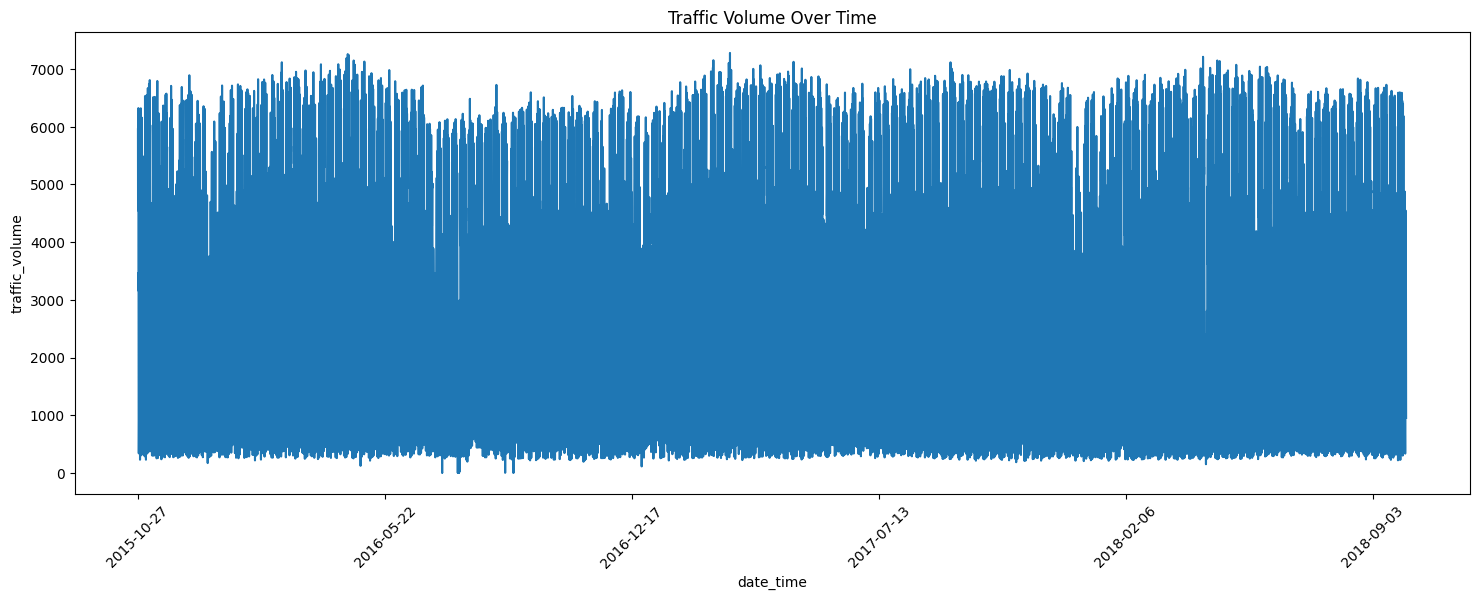

In [12]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='traffic_volume', data=df)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Traffic Volume Over Time')

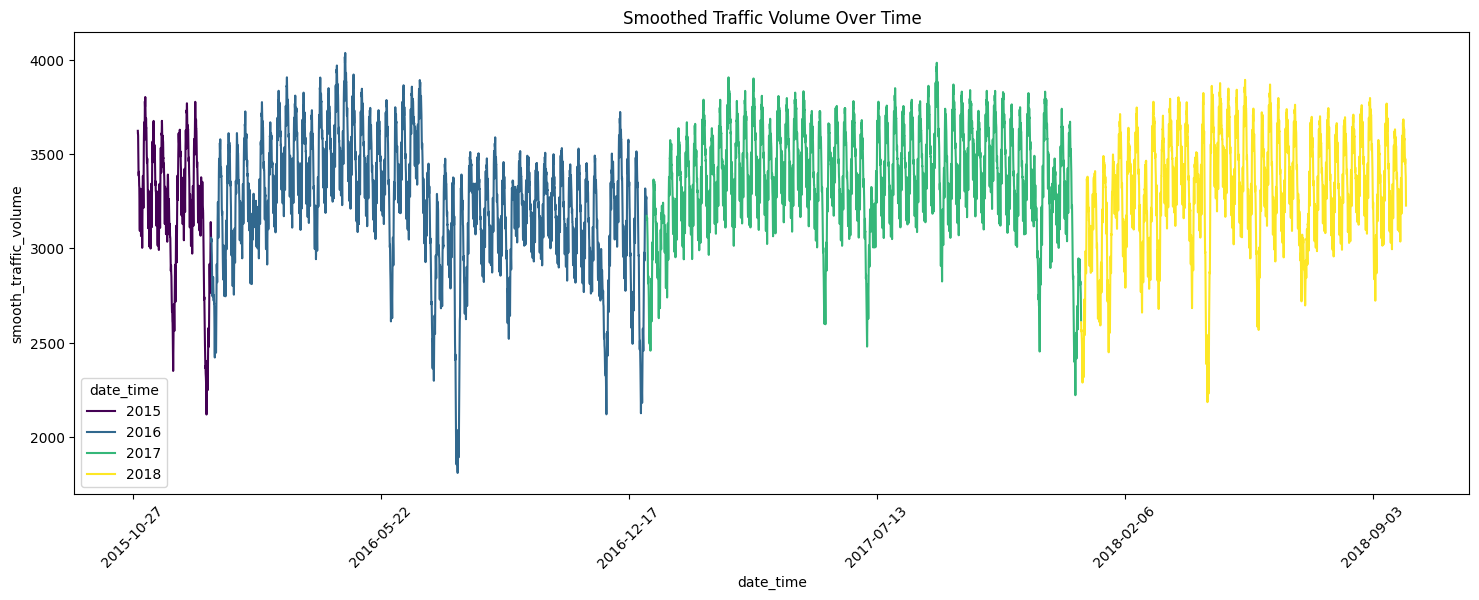

In [13]:
df['smooth_traffic_volume'] = df['traffic_volume'].rolling(window=100).mean()
colors = df.index.year
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='smooth_traffic_volume', data=df, hue=colors, palette='viridis')
plt.xticks(df.index[::5000], rotation=45)
plt.title('Smoothed Traffic Volume Over Time')
plt.show()

Text(0.5, 1.0, 'Wavelet Decomposition')

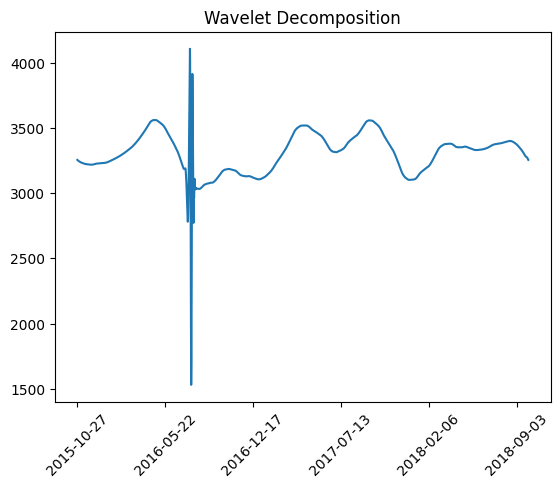

In [14]:
traffic_volume = df['traffic_volume']
coeff = pywt.wavedec(traffic_volume, 'db4', mode="per")
mean_coeff = np.mean([abs(ele - np.mean(traffic_volume)) for ele in traffic_volume])
sigma = (1 / 0.6745) * mean_coeff
threshhold = sigma * np.sqrt(2 * np.log(len(traffic_volume)))
coeff[1:] = (pywt.threshold(i, value=threshhold, mode='hard') for i in coeff[1:])
traffic_volume_wavelet_decomp = pywt.waverec(coeff, 'db4', mode='per')

plt.plot(df.index, traffic_volume_wavelet_decomp)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Wavelet Decomposition')


==> On voit quelques outliers vers le bas (regarder les dates et voir s'il y a une signification)

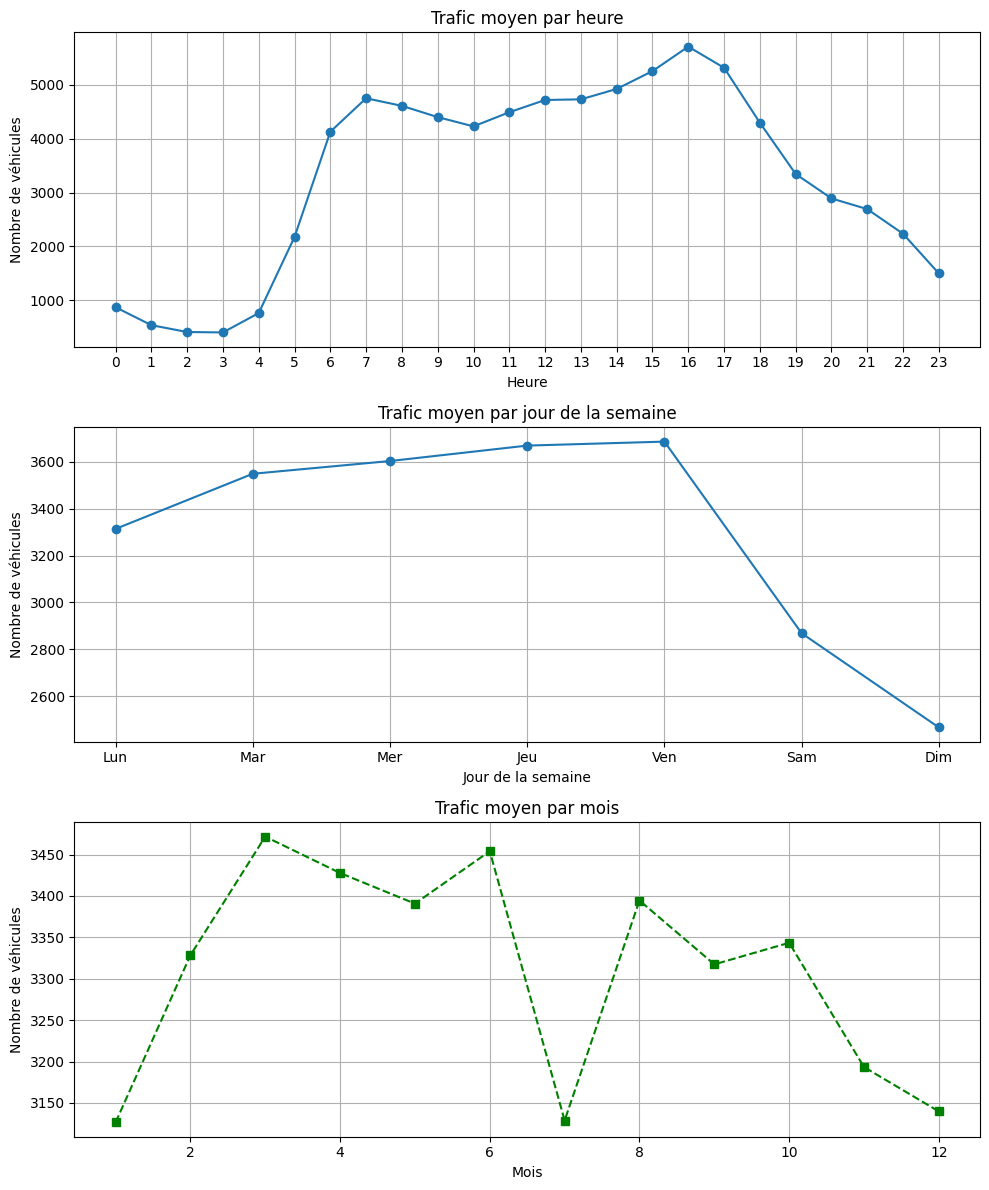

In [15]:
df["Hour"] = df.index.hour
df["Day"] = df.index.dayofweek 
df["Month"] = df.index.month

hourly_traffic = df.groupby("Hour")["traffic_volume"].mean()
daily_traffic = df.groupby("Day")["traffic_volume"].mean()
monthly_traffic = df.groupby("Month")["traffic_volume"].mean()

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

axes[0].plot(hourly_traffic.index, hourly_traffic.values, marker='o')
axes[0].set_title("Trafic moyen par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Nombre de véhicules")
axes[0].grid(True)
axes[0].set_xticks(hourly_traffic.index)


axes[1].plot(daily_traffic.index, daily_traffic.values, marker='o', linestyle='-')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"])
axes[1].set_title("Trafic moyen par jour de la semaine")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Nombre de véhicules")
axes[1].grid(True)

axes[2].plot(monthly_traffic.index, monthly_traffic.values, marker='s', linestyle='--', color='g')
axes[2].set_title("Trafic moyen par mois")
axes[2].set_xlabel("Mois")
axes[2].set_ylabel("Nombre de véhicules")
axes[2].grid(True)

plt.tight_layout()
plt.show()

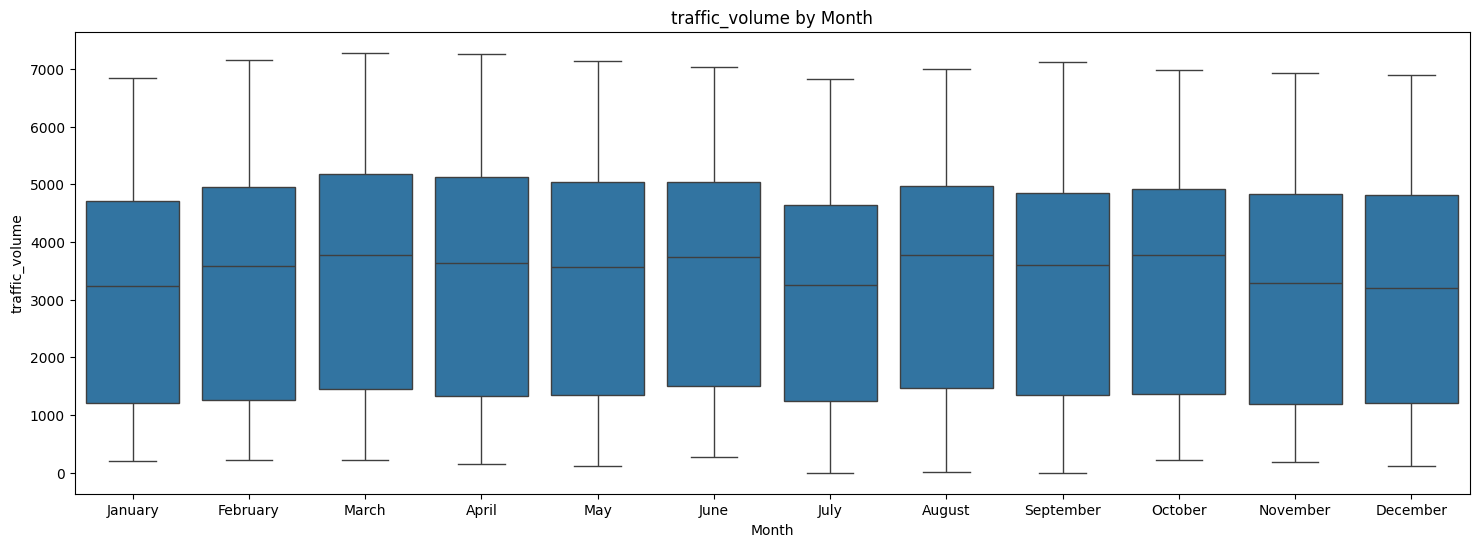

In [16]:
# box plot per month
df['Month'] = pd.Categorical(df.index.month_name(), categories=[
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
plt.figure(figsize=(18, 6))
sns.boxplot(x='Month', y='traffic_volume', data=df)
plt.title('traffic_volume by Month')
plt.show()

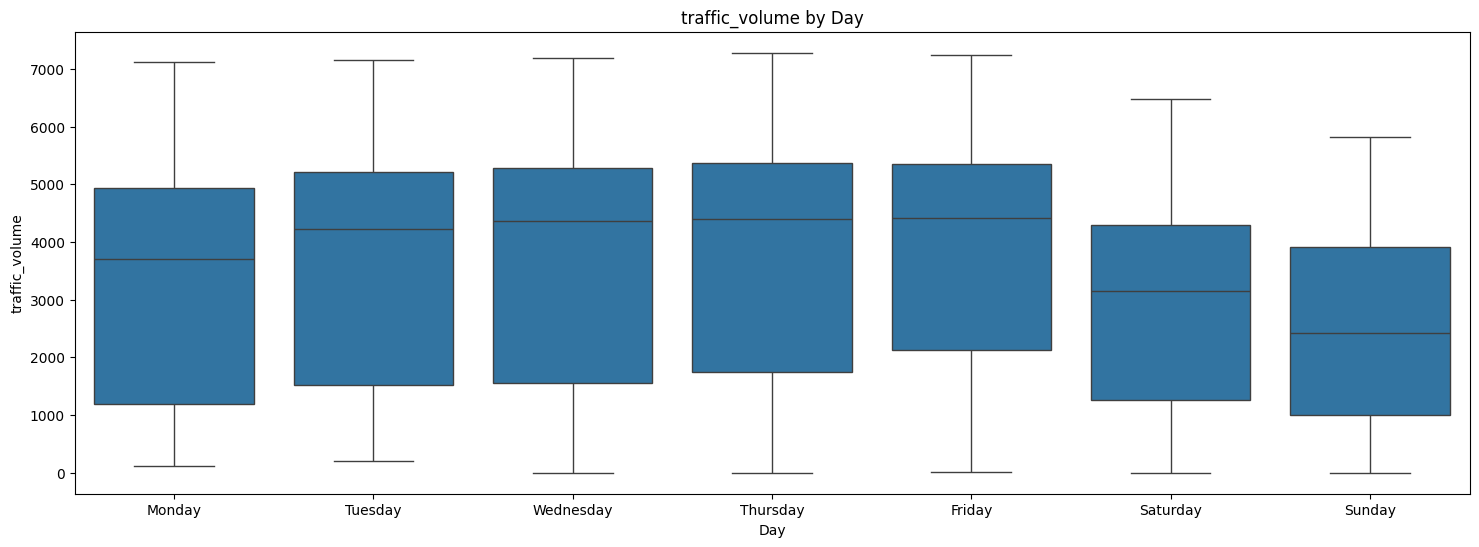

In [17]:
# box plot per day
df['Day'] = df.index.day_name()
plt.figure(figsize=(18, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='Day', y='traffic_volume', data=df, order=day_order)
plt.title('traffic_volume by Day')
plt.show()

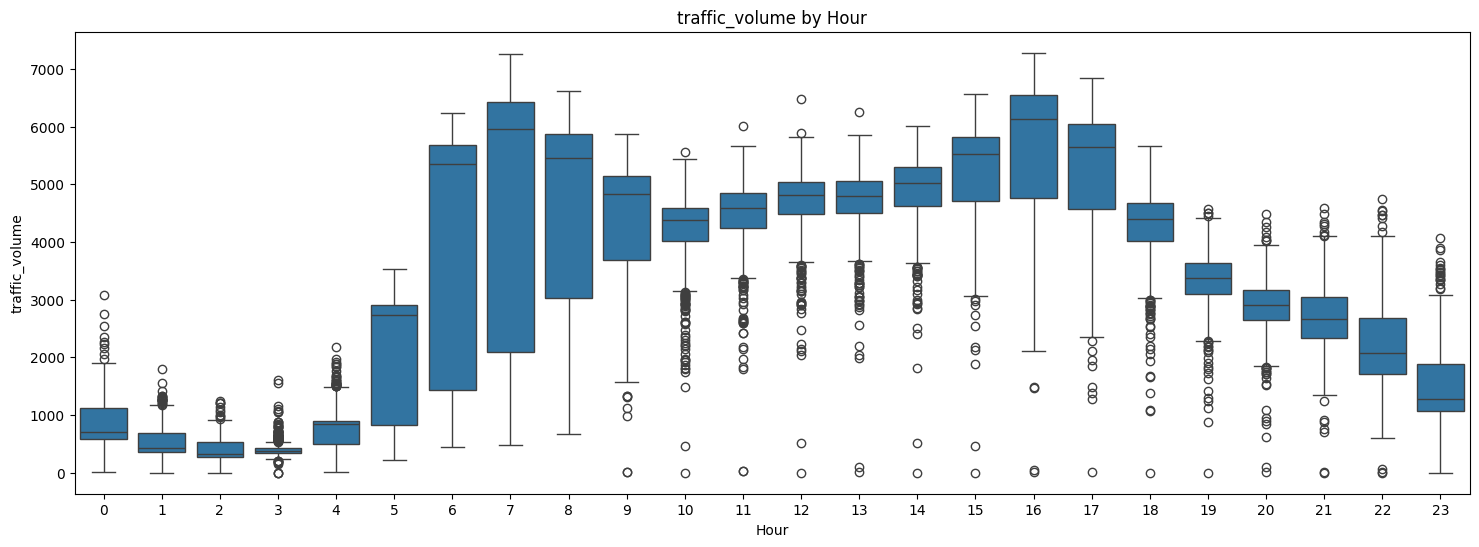

In [18]:
# box plot per hour
plt.figure(figsize=(18, 6))
sns.boxplot(x='Hour', y='traffic_volume', data=df)
plt.title('traffic_volume by Hour')
plt.show()

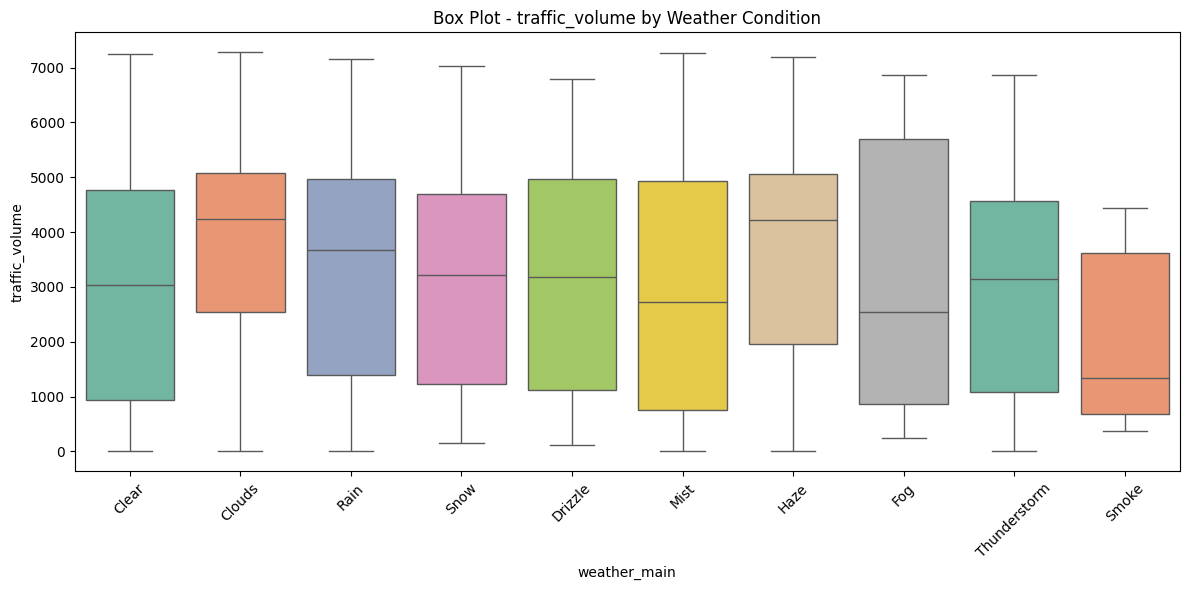

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather_main', y='traffic_volume', hue='weather_main', data=df, palette='Set2', legend=False)
plt.title('Box Plot - traffic_volume by Weather Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

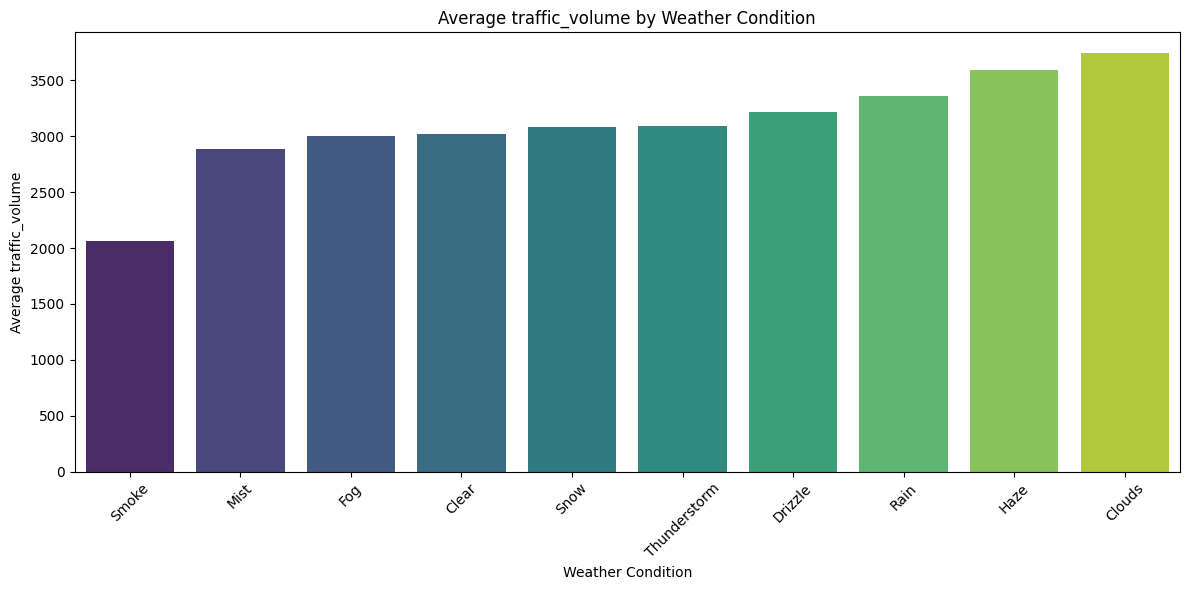

In [20]:
weather_traffic = df.groupby("weather_main", observed=True)["traffic_volume"].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_traffic.index, y=weather_traffic.values, hue=weather_traffic.index, palette='viridis', dodge=False, legend=False)
plt.title('Average traffic_volume by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average traffic_volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
result = seasonal_decompose(df["traffic_volume"], model='additive')

def plot_seasonal_decompose(result: DecomposeResult, title="Seasonal Decomposition"):
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.observed, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=title, margin=dict(t=100), title_x=0.5, showlegend=False
        )
    )

plot_seasonal_decompose(result).show()

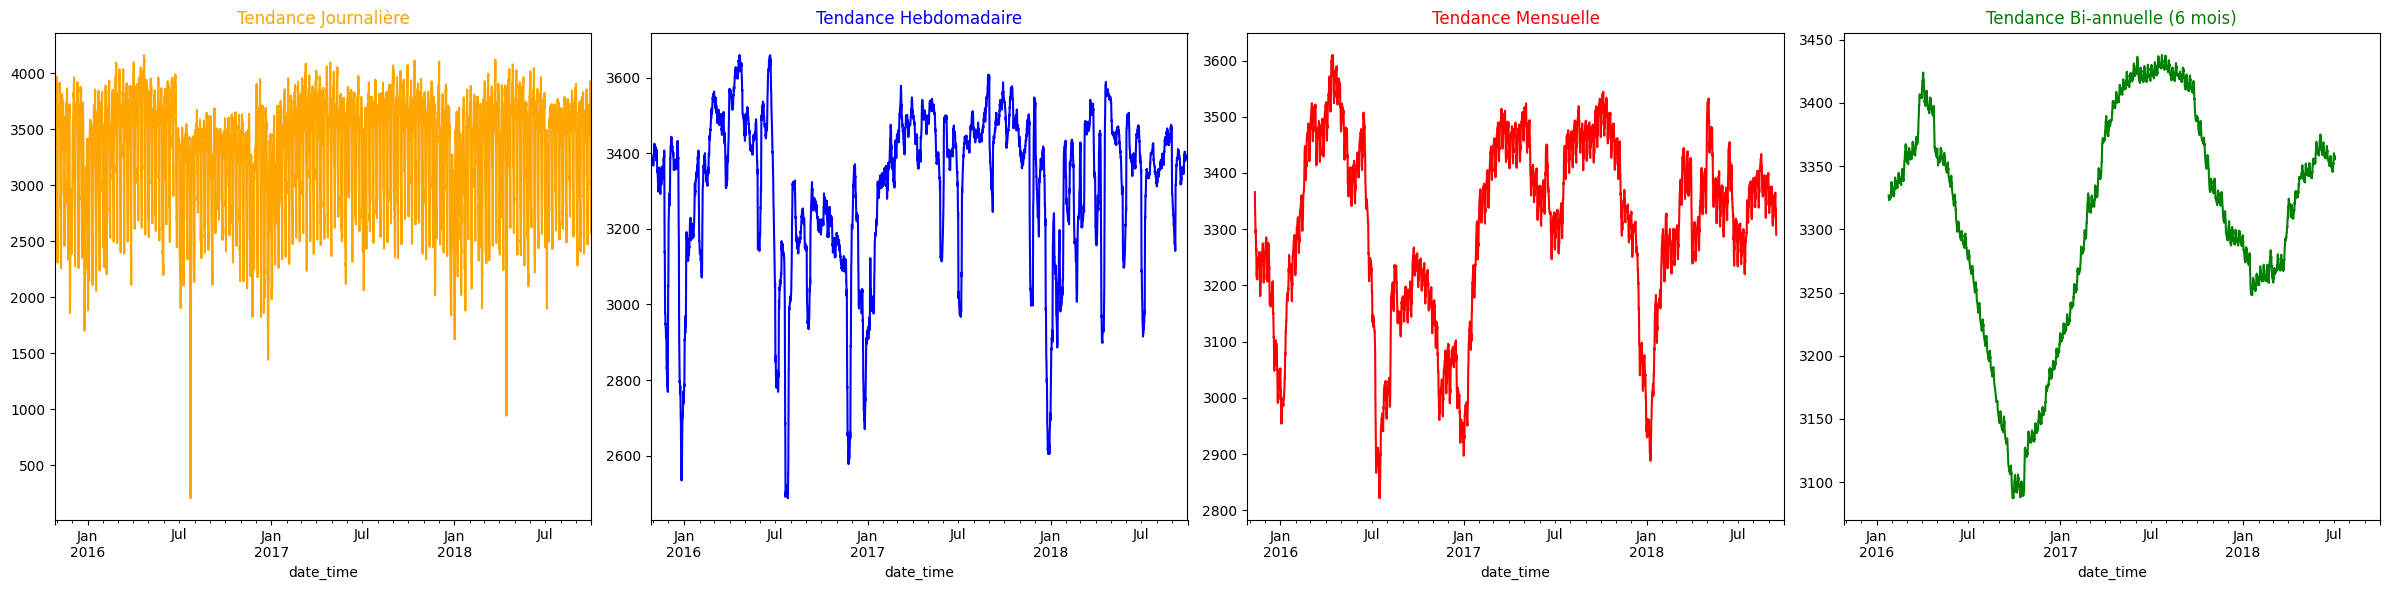

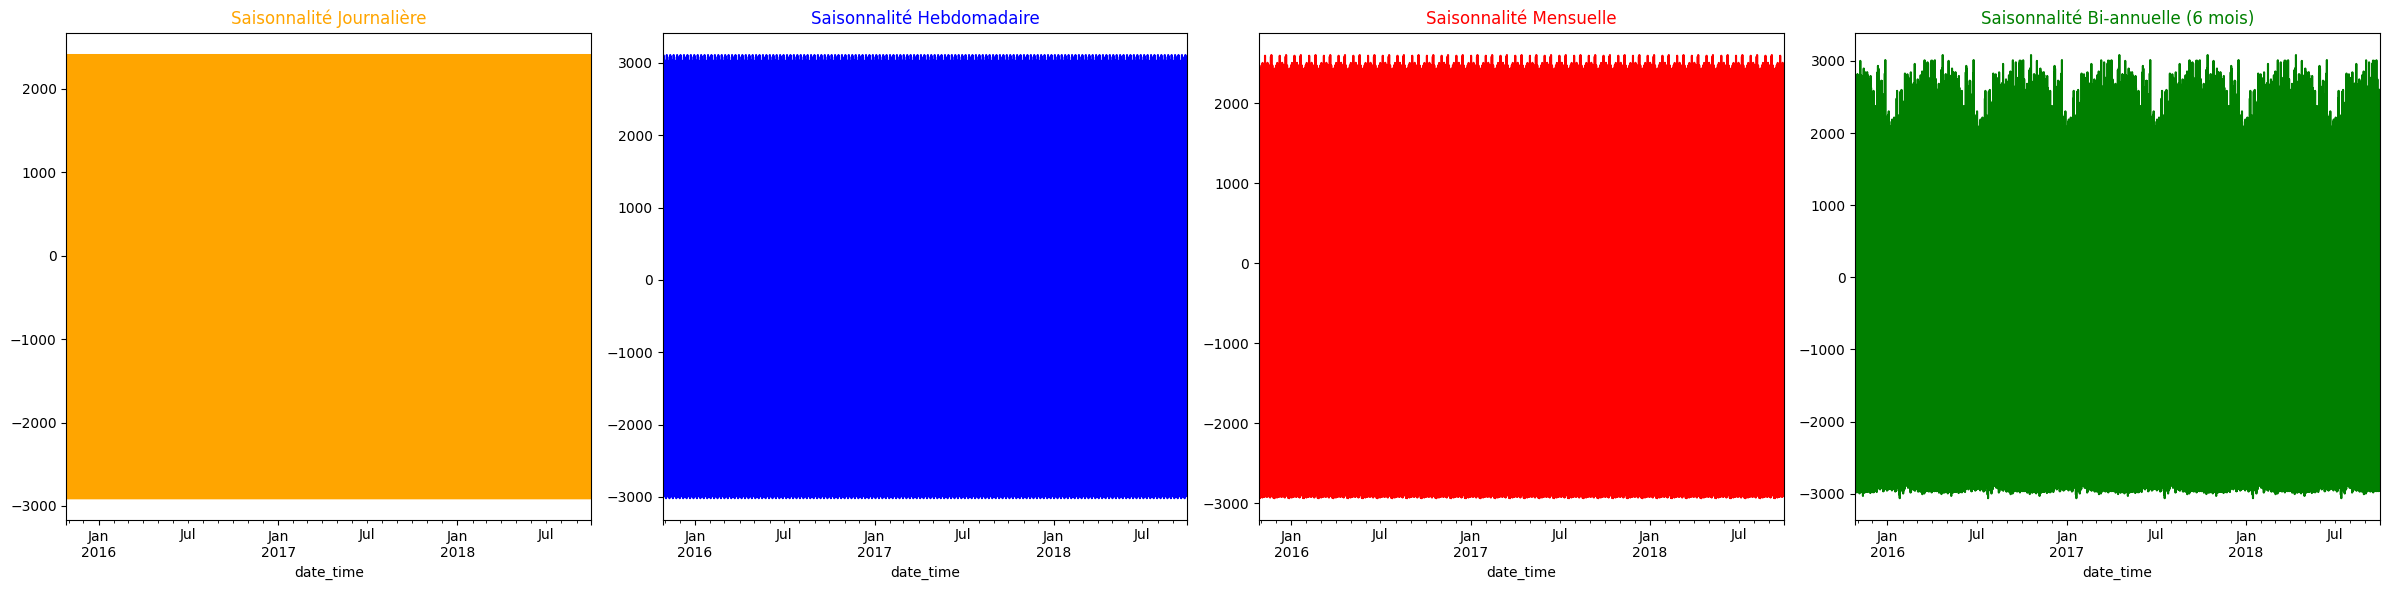

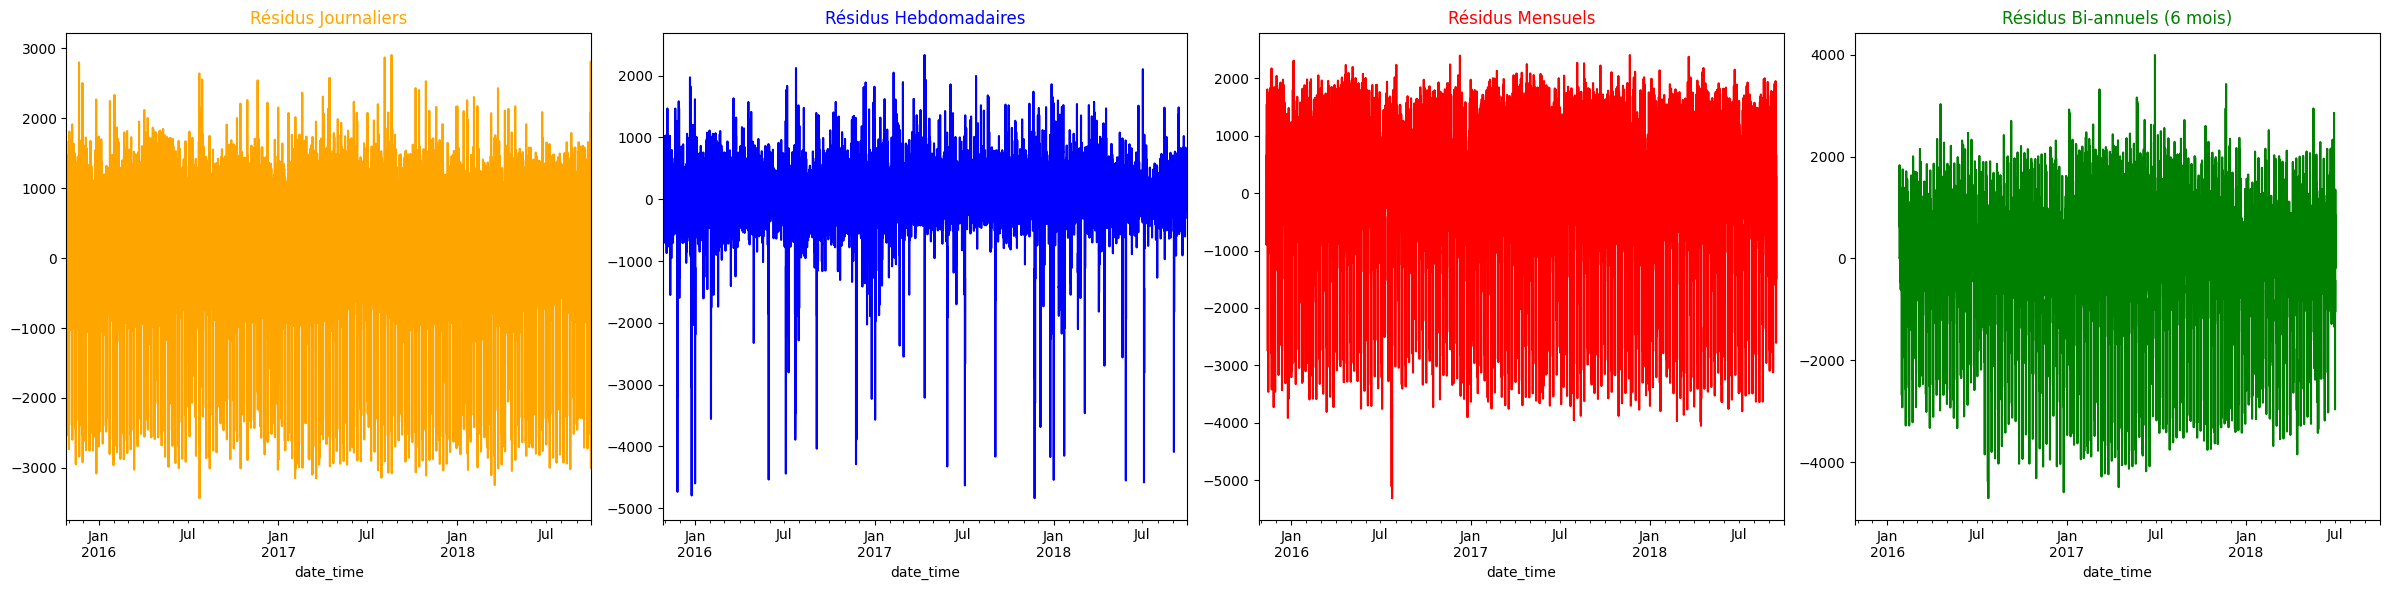

In [22]:
decomp_daily = seasonal_decompose(df["traffic_volume"], model="additive", period=24)
decomp_weekly = seasonal_decompose(df["traffic_volume"], model="additive", period=24*7)
decomp_monthly = seasonal_decompose(df["traffic_volume"], model="additive", period=24*30)
decomp_biannual = seasonal_decompose(df["traffic_volume"], model="additive", period=24*30*6)

colors = {
    "daily": "orange",
    "weekly": "blue",
    "monthly": "red",
    "biannual": "green"
}

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].set_title("Tendance Journalière", color=colors["daily"])
decomp_daily.trend.plot(ax=axes[0], color=colors["daily"])

axes[1].set_title("Tendance Hebdomadaire", color=colors["weekly"])
decomp_weekly.trend.plot(ax=axes[1], color=colors["weekly"])

axes[2].set_title("Tendance Mensuelle", color=colors["monthly"])
decomp_monthly.trend.plot(ax=axes[2], color=colors["monthly"])

axes[3].set_title("Tendance Bi-annuelle (6 mois)", color=colors["biannual"])
decomp_biannual.trend.plot(ax=axes[3], color=colors["biannual"])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].set_title("Saisonnalité Journalière", color=colors["daily"])
decomp_daily.seasonal.plot(ax=axes[0], color=colors["daily"])

axes[1].set_title("Saisonnalité Hebdomadaire", color=colors["weekly"])
decomp_weekly.seasonal.plot(ax=axes[1], color=colors["weekly"])

axes[2].set_title("Saisonnalité Mensuelle", color=colors["monthly"])
decomp_monthly.seasonal.plot(ax=axes[2], color=colors["monthly"])

axes[3].set_title("Saisonnalité Bi-annuelle (6 mois)", color=colors["biannual"])
decomp_biannual.seasonal.plot(ax=axes[3], color=colors["biannual"])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].set_title("Résidus Journaliers", color=colors["daily"])
decomp_daily.resid.plot(ax=axes[0], color=colors["daily"])

axes[1].set_title("Résidus Hebdomadaires", color=colors["weekly"])
decomp_weekly.resid.plot(ax=axes[1], color=colors["weekly"])

axes[2].set_title("Résidus Mensuels", color=colors["monthly"])
decomp_monthly.resid.plot(ax=axes[2], color=colors["monthly"])

axes[3].set_title("Résidus Bi-annuels (6 mois)", color=colors["biannual"])
decomp_biannual.resid.plot(ax=axes[3], color=colors["biannual"])

plt.tight_layout()
plt.show()


In [ ]:
lags = 48
fig, axs = plt.subplots(12, 4, figsize=(20, 30))
fig.suptitle('Lags Scatter Plots - Traffic Volume')

for i in range(1, lags + 1):
    ax = axs[(i-1)//4, (i-1)%4]
    lag = df['traffic_volume'].shift(i)
    sns.scatterplot(
        x=lag, 
        y=df['traffic_volume'], 
        ax=ax,
        color=sns.color_palette("husl", lags)[i-1]
    )
    ax.set_title(f'Lag {i}')
    ax.set_xlabel(f'Lag {i}')
    ax.set_ylabel('traffic_volume')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

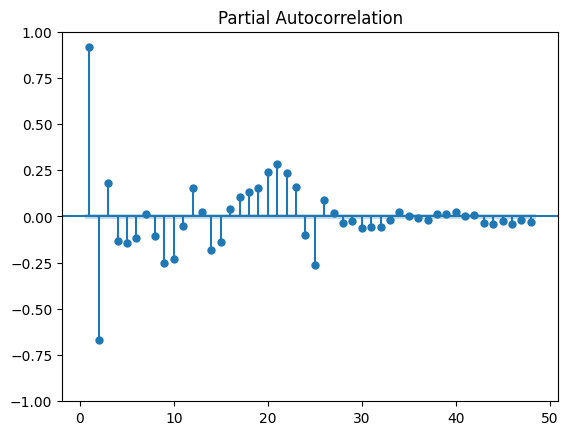

In [24]:
plot_pacf(df["traffic_volume"], lags=48, zero=False)
plt.show()

**3. Features engineering**

In [25]:
lags = [1, 2, 3, 4, 5, 6, 12, 24, 48]
# create lags columns
for lag in lags:
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)

Lags basé vite fait sur les PCAF : implémenter une méthode plus robuste

In [26]:
# create moving average column for traffic_volume
df['rolling_mean_daily'] = df['traffic_volume'].rolling(window=24).mean() # 24 hours moving average
df['rolling_mean_weekly'] = df['traffic_volume'].rolling(window=24*7).mean() # 7 days moving average
df['rolling_mean_monthly'] = df['traffic_volume'].rolling(window=24*30).mean() # 30 days moving average

On peut également calculer d'autres choses que la moyenne mobile, comme la médiane mobile, l'écart-type mobile, etc....

In [27]:
# décomposition série temporelle en "mois", "jour de la semaine", "week-end"
df['Month'] = df.index.month
df['Day'] = df.index.dayofweek
df['Weekend'] = df['Day'].isin([5, 6]).astype(int)
df["Hour"] = df.index.hour

In [28]:
df

holiday     temp  rain_1h  snow_1h  clouds_all  \
date_time                                                            
2015-10-27 08:00:00    None  281.750      0.0      0.0         1.0   
2015-10-27 09:00:00    None  282.165      0.0      0.0         1.0   
2015-10-27 10:00:00    None  282.580      0.0      0.0         1.0   
2015-10-27 11:00:00    None  283.395      0.0      0.0        45.5   
2015-10-27 12:00:00    None  284.210      0.0      0.0        90.0   
...                     ...      ...      ...      ...         ...   
2018-09-30 19:00:00    None  283.450      0.0      0.0        75.0   
2018-09-30 20:00:00    None  282.760      0.0      0.0        90.0   
2018-09-30 21:00:00    None  282.730      0.0      0.0        90.0   
2018-09-30 22:00:00    None  282.090      0.0      0.0        90.0   
2018-09-30 23:00:00    None  282.120      0.0      0.0        90.0   

                     weather_main     weather_description  traffic_volume  \
date_time                                                                   
2015-10-27 08:00:00         Clear            sky is clear          5957.0   
2015-10-27 09:00:00          None                    None          5253.0   
2015-10-27 10:00:00         Clear            sky is clear          4549.0   
2015-10-27 11:00:00          None                    None          4664.5   
2015-10-27 12:00:00        Clouds         overcast clouds          4780.0   
...                           ...                     ...             ...   
2018-09-30 19:00:00        Clouds           broken clouds          3543.0   
2018-09-30 20:00:00        Clouds         overcast clouds          2781.0   
2018-09-30 21:00:00  Thunderstorm  proximity thunderstorm          2159.0   
2018-09-30 22:00:00        Clouds         overcast clouds          1450.0   
2018-09-30 23:00:00        Clouds         overcast clouds           954.0   

                     smooth_traffic_volume  Hour  ...   lag_4   lag_5   lag_6  \
date_time                                         ...                           
2015-10-27 08:00:00                    NaN     8  ...     NaN     NaN     NaN   
2015-10-27 09:00:00                    NaN     9  ...     NaN     NaN     NaN   
2015-10-27 10:00:00                    NaN    10  ...     NaN     NaN     NaN   
2015-10-27 11:00:00                    NaN    11  ...     NaN     NaN     NaN   
2015-10-27 12:00:00                    NaN    12  ...  5957.0     NaN     NaN   
...                                    ...   ...  ...     ...     ...     ...   
2018-09-30 19:00:00                3359.88    19  ...  4302.0  4380.0  4547.0   
2018-09-30 20:00:00                3324.35    20  ...  4283.0  4302.0  4380.0   
2018-09-30 21:00:00                3286.40    21  ...  4132.0  4283.0  4302.0   
2018-09-30 22:00:00                3254.29    22  ...  3947.0  4132.0  4283.0   
2018-09-30 23:00:00                3227.44    23  ...  3543.0  3947.0  4132.0   

                     lag_12  lag_24  lag_48  rolling_mean_daily  \
date_time                                                         
2015-10-27 08:00:00     NaN     NaN     NaN                 NaN   
2015-10-27 09:00:00     NaN     NaN     NaN                 NaN   
2015-10-27 10:00:00     NaN     NaN     NaN                 NaN   
2015-10-27 11:00:00     NaN     NaN     NaN                 NaN   
2015-10-27 12:00:00     NaN     NaN     NaN                 NaN   
...                     ...     ...     ...                 ...   
2018-09-30 19:00:00  1175.0  3818.0  4286.0         2729.583333   
2018-09-30 20:00:00  2002.0  3338.0  3538.0         2706.375000   
2018-09-30 21:00:00  2882.0  2950.0  3058.0         2673.416667   
2018-09-30 22:00:00  3701.0  2607.0  2713.0         2625.208333   
2018-09-30 23:00:00  4049.0  3856.0  3544.0         2504.291667   

                     rolling_mean_weekly  rolling_mean_monthly  Weekend  
date_time                                                                
2015-10-27 08:00:00              

D'autres features à tester:
- Encodage cyclique 
- TSFresh
- Target engineering (box-cox, differentiation)
- Intégrer les autres features de météo?

In [31]:
features = ["traffic_volume", "weather_main", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_12", "lag_24", "lag_48", "rolling_mean_daily", "rolling_mean_weekly", "rolling_mean_monthly", "Month", "Day", "Weekend", "Hour"]

df = df[features].dropna()
print(df.shape)
df.head()

(24953, 18)


traffic_volume weather_main   lag_1   lag_2   lag_3  \
date_time                                                                  
2015-11-26 07:00:00          1010.5         None   827.0   549.5   272.0   
2015-11-26 08:00:00          1194.0         Snow  1010.5   827.0   549.5   
2015-11-26 09:00:00          1668.0         None  1194.0  1010.5   827.0   
2015-11-26 10:00:00          2142.0         Snow  1668.0  1194.0  1010.5   
2015-11-26 11:00:00          2687.0         None  2142.0  1668.0  1194.0   

                      lag_4  lag_5  lag_6  lag_12  lag_24  lag_48  \
date_time                                                           
2015-11-26 07:00:00   324.5  377.0  605.0  3769.5  5306.0  6709.0   
2015-11-26 08:00:00   272.0  324.5  377.0  3419.0  5181.0  5891.5   
2015-11-26 09:00:00   549.5  272.0  324.5  2841.5  4951.5  5074.0   
2015-11-26 10:00:00   827.0  549.5  272.0  2264.0  4722.0  4834.5   
2015-11-26 11:00:00  1010.5  827.0  549.5  1548.5  5136.5  4595.0   

                     rolling_mean_daily  rolling_mean_weekly  \
date_time                                                      
2015-11-26 07:00:00         3204.854167          3325.601190   
2015-11-26 08:00:00         3038.729167          3298.250000   
2015-11-26 09:00:00         2901.916667          3277.312500   
2015-11-26 10:00:00         2794.416667          3262.788690   
2015-11-26 11:00:00         2692.354167          3249.511905   

                     rolling_mean_monthly  Month  Day  Weekend  Hour  
date_time                                                             
2015-11-26 07:00:00           3369.047917     11    3        0     7  
2015-11-26 08:00:00           3362.432639     11    3        0     8  
2015-11-26 09:00:00           3357.453472     11    3        0     9  
2015-11-26 10:00:00           3354.110417     11    3        0    10  
2015-11-26 11:00:00           3351.363889     11    3        0    11

In [32]:
df = pd.get_dummies(df, columns=["weather_main"], drop_first=True) # one hot encoding, on peut tester le target encoding, également sur les autres variables catégorielles mais attention au risque de fuite de données
df.head()

traffic_volume   lag_1   lag_2   lag_3   lag_4  lag_5  \
date_time                                                                    
2015-11-26 07:00:00          1010.5   827.0   549.5   272.0   324.5  377.0   
2015-11-26 08:00:00          1194.0  1010.5   827.0   549.5   272.0  324.5   
2015-11-26 09:00:00          1668.0  1194.0  1010.5   827.0   549.5  272.0   
2015-11-26 10:00:00          2142.0  1668.0  1194.0  1010.5   827.0  549.5   
2015-11-26 11:00:00          2687.0  2142.0  1668.0  1194.0  1010.5  827.0   

                     lag_6  lag_12  lag_24  lag_48  ...  weather_main_Clouds  \
date_time                                           ...                        
2015-11-26 07:00:00  605.0  3769.5  5306.0  6709.0  ...                False   
2015-11-26 08:00:00  377.0  3419.0  5181.0  5891.5  ...                False   
2015-11-26 09:00:00  324.5  2841.5  4951.5  5074.0  ...                False   
2015-11-26 10:00:00  272.0  2264.0  4722.0  4834.5  ...                False   
2015-11-26 11:00:00  549.5  1548.5  5136.5  4595.0  ...                False   

                     weather_main_Drizzle  weather_main_Fog  \
date_time                                                     
2015-11-26 07:00:00                 False             False   
2015-11-26 08:00:00                 False             False   
2015-11-26 09:00:00                 False             False   
2015-11-26 10:00:00                 False             False   
2015-11-26 11:00:00                 False             False   

                     weather_main_Haze  weather_main_Mist  weather_main_None  \
date_time                                                                      
2015-11-26 07:00:00              False              False               True   
2015-11-26 08:00:00              False              False              False   
2015-11-26 09:00:00              False              False               True   
2015-11-26 10:00:00              False              False              False   
2015-11-26 11:00:00              False              False               True   

                     weather_main_Rain  weather_main_Smoke  weather_main_Snow  \
date_time                                                                       
2015-11-26 07:00:00              False               False              False   
2015-11-26 08:00:00              False               False               True   
2015-11-26 09:00:00              False               False              False   
2015-11-26 10:00:00              False               False               True   
2015-11-26 11:00:00              False               False              False   

                     weather_main_Thunderstorm  
date_time                                       
2015-11-26 07:00:00                      False  
2015-11-26 08:00:00                      False  
2015-11-26 09:00:00                      False  
2015-11-26 10:00:00                      False  
2015-11-26 11:00:00                      False  

[5 rows x 27 columns]

**Préparation à la modélisation**